### Tutorial on QAOA Compiler

This tutorial shows how to use the QAOA compiler for agressive circuit optimizations on QAOA workloads. (https://github.com/mahabubul-alam/QAOA-Compiler).

### Inputs to the QAOA Compiler
The compiler takes three json files as the inputs. They holds the following information:
* ZZ-interactions and corresponding coefficients in the problem Hamiltonian (https://github.com/mahabubul-alam/QAOA-Compiler/blob/main/examples/QAOA_circ.json)
* Target hardware supported gates and corresponding reliabilities (https://github.com/mahabubul-alam/QAOA-Compiler/blob/main/examples/QC.json)
* Confugurations for compilation (e.g., target p-value, routing method, random seed, etc.) (https://github.com/mahabubul-alam/QAOA-Compiler/blob/main/examples/Config.json)

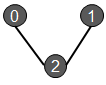

The input ZZ-interactions json file content for the above graph MaxCut problem is shown below:

```
{
    "(0, 2)": "-0.5", // ZZ-interaction between the qubit pair (0, 2) with a coefficient of -0.5 
    "(1, 2)": "-0.5"
}
```

A script is provided under utils (https://github.com/mahabubul-alam/QAOA-Compiler/blob/main/utils/construct_qaoa_circ_json.py) to generate this input json file for arbitrary unweighted graph.

The hardware json file must have the following information:
* Supported single-qubit gates
* Supported two-qubit gate
* Reliabilities of the supported single qubit operations
* Reliabilities of the supported two-qubit operations <br>

The json file content for a hypothetical 3-qubit hardware is shown below:

```
{
    "1Q": [ //native single-qubit gates of the target hardware
        "u3"
    ],
    "2Q": [ //native two-qubit gate of the target hardware
        "cx"
    ],
    "u3": {
        "0": 0.991, //"qubit" : success probability of u3
        "1": 0.995,
        "2": 0.998
    }
    "cx": {
        "(0,1)": 0.96, //"(qubit1,qubit2)" : success probability of cx between qubit1, qubit2 (both directions)
        "(1,2)": 0.97,
        "(2,0)": 0.98,
    }
}
    
```

A script is provided under utils (https://github.com/mahabubul-alam/QAOA-Compiler/blob/main/utils/construct_qc.py) to generate this json file for the quantum processors from IBM.

The configuration json file should hold the following information:
* Target backend compiler (currently supports qiskit)
* Target p-value
* Packing Limit (see https://www.microarch.org/micro53/papers/738300a215.pdf)
* Target routing method (any routing method that are supported by the qiskit compiler, e.g., sabre, stochastic_swap, basic_swap, etc.)
* Random seed for the qiskit transpiler
* Chosen optimization level for the qiskit compiler (0~3)

The content of a sample configuration json file is shown below:

```
{
        "Backend" : "qiskit",
        "Target_p" : "1",
        "Packing_Limit" : "10e10",
        "Route_Method" : "sabre",
        "Trans_Seed" : "0",
        "Opt_Level" : "3"
}
```

### How to Run
```
python run.py -arg arg_val
```
* -device_json string (mandatory): Target device configuration file location. This file holds the information on basis gates, reliability, and allowed two-qubit operations. It has to be written in json format. An example can be found [here](https://github.com/mahabubul-alam/QAOA_Compiler/blob/main/examples/QC.json).

* -circuit_json string (mandatory): Problem QAOA-circuit file location. This file holds the required ZZ interactions between various qubit-pairs to encode the cost hamiltonian. It has to be written in json format. An example can be found [here](https://github.com/mahabubul-alam/QAOA_Compiler/blob/main/examples/QAOA_circ.json).

* -config_json string (mandatory): Compiler configuration file location. This file holds target p-level, and chosen packing limit, qiskit transpiler seed, optimization level, and routing method. It has to be written in json format. An example can be found [here](https://github.com/mahabubul-alam/QAOA_Compiler/blob/main/examples/Config.json).

* -policy_compilation string: Chosen compilation policy. The current version supports the following policies: Instruction Parallelization-only ('IP'), Iterative Compilation ('IterC'), Incremental Compilation ('IC'), Variation-aware Incremental Compilation ('VIC'). The default value is 'IC'.

* -target_IterC string: Minimization objective of Iterative Compilation. The current version supports the following minimization objectives: Circuit Depth ('D'), Native two-qubit gate-count ('GC_2Q'), Estimated Success Probability ('ESP'). The default value is 'GC_2Q'.

* -initial_layout_method string: The chosen initial layout method. Currently supported methods: 'vqp', 'qaim', 'random'. The default method is 'qaim'.

* -output_qasm_file_name string: File name to write the compiled parametric QAOA circuit. The output is written in qasm format. The default value is 'QAOA.qasm'. The output qasm files are written following this naming style: {Method(IP/IC/VIC/IterC)}_{output_qasm_file_name}.


In [7]:
!python run.py -device_json examples/QC.json -circuit_json examples/QAOA_circ.json -config_json examples/Config.json  -policy_compilation VIC -initial_layout_method vqp

############################################################################
Variation-aware Incremental Compilation (VIC) completed (initial layout: vqp)!
QASM File Written: VIC_QAOA.qasm
##################### Notes on the Output File #############################
(naive) Depth: 130, gate-count(2Q): 227, ESP: 0.0019301743858659978
(VIC) Depth: 69, gate-count(2Q): 151, ESP: 0.015510689327353987
The circuit is written with beta/gamma parameters at different p-lavels (https://arxiv.org/pdf/1411.4028.pdf)
bX --> beta parameter at p=X
gX --> gamma parameter at p=X (https://arxiv.org/pdf/1411.4028.pdf)
############################################################################


### Output QAOA Circuits

The tool generates 3 QASM files:
* The uncompiled circuit (https://github.com/mahabubul-alam/QAOA-Compiler/blob/main/uncompiled_QAOA.qasm)
* Compiled QAOA circuit with conventinal approach (https://github.com/mahabubul-alam/QAOA-Compiler/blob/main/naive_compiled_QAOA.qasm)
* Optimized QAOA circuit with chosen set of optimization policies (https://github.com/mahabubul-alam/QAOA-Compiler/blob/main/VIC_QAOA.qasm)

A sample QASM file is shown below:

In [8]:
!cat VIC_QAOA.qasm

OPENQASM 2.0;
include "qelib1.inc";
qreg q[20];
creg c[12];
h q[4];
h q[2];
h q[3];
h q[14];
h q[11];
h q[7];
h q[9];
h q[16];
h q[19];
h q[10];
h q[5];
h q[17];
cx q[4],q[7];
u3(0,0,-1.0*g1) q[7];
cx q[4],q[7];
cx q[9],q[5];
u3(0,0,-1.0*g1) q[5];
cx q[9],q[5];
cx q[11],q[2];
u3(0,0,-1.0*g1) q[2];
cx q[11],q[2];
cx q[3],q[14];
u3(0,0,-1.0*g1) q[14];
cx q[3],q[14];
cx q[10],q[17];
u3(0,0,-1.0*g1) q[17];
cx q[10],q[17];
cx q[16],q[19];
u3(0,0,-1.0*g1) q[19];
cx q[16],q[19];
cx q[3],q[7];
u3(0,0,-1.0*g1) q[7];
cx q[3],q[7];
cx q[11],q[5];
u3(0,0,-1.0*g1) q[5];
cx q[11],q[5];
cx q[14],q[10];
u3(0,0,-1.0*g1) q[10];
cx q[14],q[10];
cx q[9],q[16];
u3(0,0,-1.0*g1) q[16];
cx q[9],q[16];
cx q[2],q[16];
cx q[16],q[2];
cx q[2],q[16];
cx q[4],q[19];
u3(0,0,-1.0*g1) q[19];
cx q[4],q[19];
cx q[17],q[19];
cx q[19],q[17];
cx q[17],q[19];
cx q[16],q[19];
u3(0,0,-1.0*g1) q[19];
cx q[16],q[19];
cx q[4],q[3];
u3(0,0,-1.0*g1) q[3];
cx q[4],q[3];
cx q[11],q[2];
u3(0,0,-1.0*g1) q[2];
cx q[11],q[2];
cx q[14],q